# Traditional DoE vs. Bayesian Optimization

The [first](https://youtu.be/Evua529dAgc) and
[second](https://youtu.be/41fQs4JxRQA) videos from Taylor Sparks' [Optimization Tutorial
YouTube playlist](https://youtube.com/playlist?list=PLL0SWcFqypClTIMQDOs_Jug70qaVPOzEc)
are based on the results from this notebook. I suggest watching these two videos prior
to working through this notebook for better context.

This notebook first describes uninformed
sampling methods including random, grid, and quasi-random (e.g., Latin hypercube, Sobol
sequences) and shows how quasi-random achieves a much more even distribution of points.
Finally, we compare the efficiency of these traditional methods for design of
experiments (DoE) against Bayesian optimization. We show that, on average, Bayesian
optimization is much more efficient than traditional DoE.

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import qmc
from os import path
from self_driving_lab_demo.utils.plotting import plot_and_save

/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <5FBFC0F3-C069-3EF4-9857-B165E58FADBC> /Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <22270481-544D-33A2-9FD1-270293676910> /Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
bounds = {"radius": [0.90, 2.65], "phi": [0,np.pi/2], "theta": [-np.pi/2,np.pi/2], "thickness": [0.05,0.15], "length": [0,2.00] }
num_samples = len(bounds)*10
num_samples_1 = len(bounds)*1
num_samples_2 = len(bounds)*2
num_digits = 2

## Uninformed Sampling Methods

These are sampling methods that do not incorporate information about the objective function
to be optimized. We will cover grid search, random search, and two quasi-random methods:
Latin hypercube and Sobol sequences.

### Grid

Grid sampling is a structured approach to sampling from a search space. It involves
creating a grid of points over the space, and then selecting points from the grid. When
grids are used for certain types of problems (e.g., finite element methods), the
algorithms are often more straightforward than for non-lattice point sets. This can be
an effective way to ensure that the entire search space is explored, but it can also
lead to a lot of unnecessary points being generated, especially for high-dimensional
search spaces, due to large, systematic "pockets" in the search space.


In [3]:
from sklearn.model_selection import ParameterGrid

def get_grid_samples(bounds, num_samples = 10, seed=None):
    # seed is unused, for compatibility only
    param_grid = {}
    num_pts_per_dim = max(1, np.floor(num_samples ** (1 / len(bounds))).astype(int))
    for name, bnd in bounds.items():
        param_grid[name] = np.linspace(bnd[0], bnd[1], num=num_pts_per_dim)
    print(len(bounds)**num_pts_per_dim)
    return pd.DataFrame(list(ParameterGrid(param_grid)))

def get_grid_samples_extended(bounds, num_samples=10, seed=None):
    grid_samples_1 = get_grid_samples(bounds, num_samples,seed=seed)
    grid_samples_2 = get_grid_samples(bounds, num_samples*2,seed=seed)
    return pd.concat([grid_samples_1,grid_samples_2],ignore_index=True,sort=False)

grid_samples = get_grid_samples_extended(bounds, num_samples,seed=None)
grid_samples

25
25


,length,phi,radius,theta,thickness
0,0.0,0.000000,0.90,-1.570796,0.05
1,0.0,0.000000,0.90,-1.570796,0.15
2,0.0,0.000000,0.90,1.570796,0.05
3,0.0,0.000000,0.90,1.570796,0.15
4,0.0,0.000000,2.65,-1.570796,0.05
...,...,...,...,...,...
59,2.0,1.570796,0.90,1.570796,0.15
60,2.0,1.570796,2.65,-1.570796,0.05
61,2.0,1.570796,2.65,-1.570796,0.15
62,2.0,1.570796,2.65,1.570796,0.05


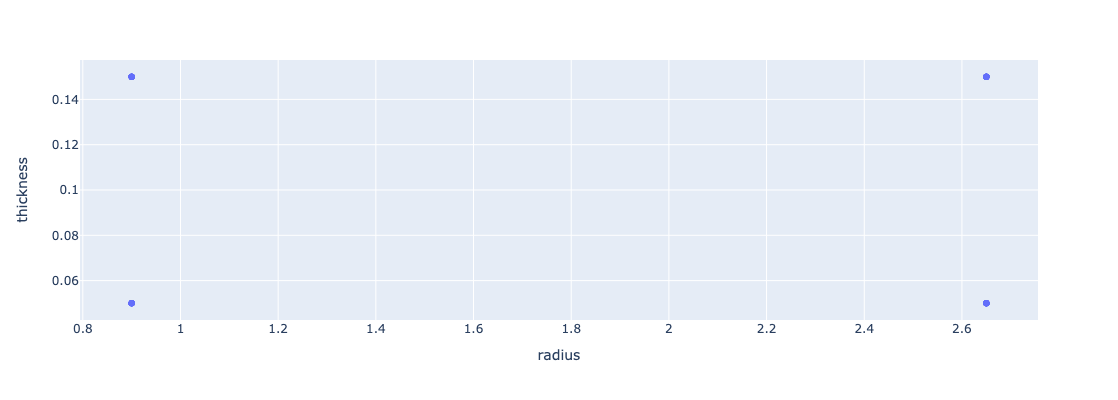

In [4]:
grid_fig = px.scatter(grid_samples, x="radius", y="thickness", width=400, height=400)
grid_fig


### Random

Random sampling is a simple and straightforward method for generating samples from a
search space. It involves randomly selecting points from the space, without any regard
for their distribution. This can be an effective method for exploring search spaces, and
it is often more effective than grid search. While it doesn't have the large, systematic
pockets characteristic of grid search, it has large, occasional gaps due to the random
nature of the search.

In [5]:
from numpy.random import default_rng

def get_random_samples(bounds, num_samples=9, seed=None):
    rng = default_rng(seed)
    samples = {}
    for parameter, bound in bounds.items():
        samples[parameter] = rng.uniform(bound[0], bound[1], num_samples)
        samples[parameter] = np.round(samples[parameter],num_digits)
    return pd.DataFrame(samples)

def get_random_samples_extended(bounds, num_samples=10, seed=None):
    random_samples_1 = get_random_samples(bounds, num_samples,seed=seed)
    random_samples_2 = get_random_samples(bounds, num_samples*2,seed=seed)
    return pd.concat([random_samples_1,random_samples_2],ignore_index=True,sort=False)

random_samples = get_random_samples_extended(bounds, num_samples,seed=None)
random_samples


,radius,phi,theta,thickness,length
0,1.65,1.11,0.69,0.10,0.10
1,2.41,0.52,1.11,0.06,0.49
2,2.29,0.94,0.83,0.06,1.71
3,1.77,0.23,0.64,0.10,0.45
4,1.39,0.41,-1.40,0.14,1.70
...,...,...,...,...,...
145,1.28,0.81,-0.05,0.14,0.40
146,1.16,1.34,1.26,0.12,1.91
147,2.32,1.39,1.00,0.07,0.43
148,1.23,0.05,0.28,0.10,1.74


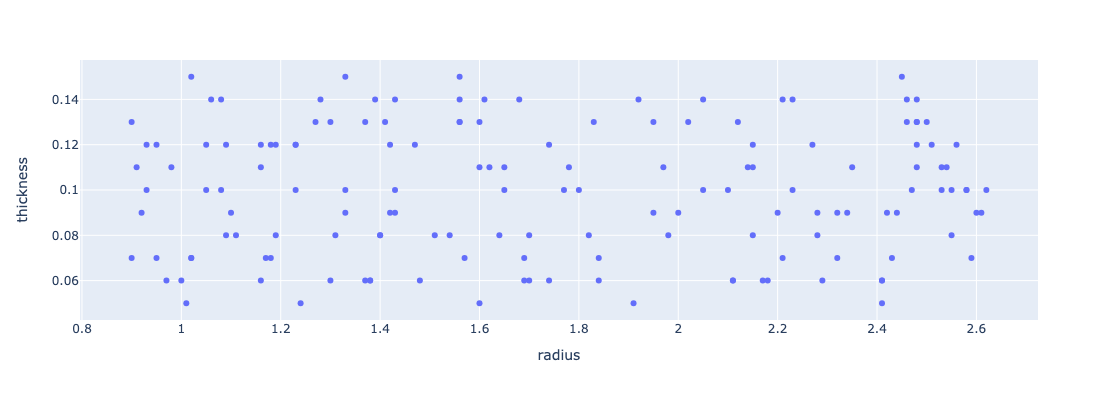

In [6]:
random_fig = px.scatter(random_samples, x="radius", y="thickness", width=400, height=400)
random_fig

## Quasi-Random

Quasi-random sampling methods, also known as low-discrepancy or deterministic sampling methods, are a family of sampling techniques that are designed to
produce samples that are more evenly distributed than random samples. Unlike random
sampling, which selects points randomly and independently, quasi-random sampling methods
aim to achieve a more uniform coverage of the parameter space by reducing the
**discrepancy** between the generated points and the desired distribution.

We'll discuss two common quasi-random sampling methods: Latin hypercube and
Sobol sequences.

### Latin Hypercube

Latin hypercube sampling (LHS) is a variation of grid sampling that aims to improve the
uniformity of the samples. It does this by ensuring that each dimension of the search
space is represented equally in the sample set. It involves dividing the parameter space
into equally spaced intervals and randomly selecting one point within each interval. LHS
ensures a more even coverage of the parameter space compared to random or grid sampling
methods (i.e., lower discrepancy).

In [7]:
def get_latin_hypercube_samples(bounds, num_samples=10, seed=None):
    sampler = qmc.LatinHypercube(d=len(bounds), optimization="random-cd", seed=seed)
    samples = sampler.random(num_samples)
    l_bounds = [bound[0] for bound in bounds.values()]
    u_bounds = [bound[1] for bound in bounds.values()]
    samples = qmc.scale(samples, l_bounds, u_bounds)
    samples=np.round(samples,num_digits)
    return pd.DataFrame(samples, columns=list(bounds.keys()))

def get_latin_hypercube_samples_extended(bounds, num_samples=10, seed=None):
    latin_hypercube_samples_1 = get_latin_hypercube_samples(bounds, num_samples,seed=seed)
    latin_hypercube_samples_2 = get_latin_hypercube_samples(bounds, num_samples*2,seed=seed)
    return pd.concat([latin_hypercube_samples_1,latin_hypercube_samples_2],ignore_index=True,sort=False)

latin_hypercube_samples = get_latin_hypercube_samples_extended(bounds, num_samples,seed=None)
latin_hypercube_samples


,radius,phi,theta,thickness,length
0,2.54,1.10,0.02,0.07,1.98
1,2.18,0.75,-0.82,0.09,1.43
2,1.37,0.70,-1.05,0.13,1.32
3,1.81,0.34,-1.55,0.12,1.59
4,1.26,1.39,1.46,0.12,0.42
...,...,...,...,...,...
145,2.24,1.23,1.41,0.13,0.46
146,1.66,1.00,-0.34,0.11,1.14
147,2.59,0.08,-0.71,0.12,1.10
148,1.57,0.03,-1.45,0.14,0.81


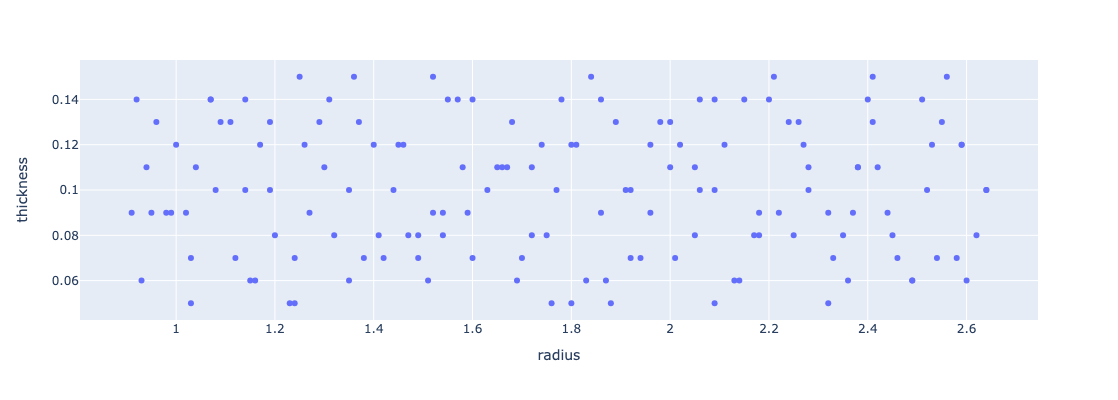

In [8]:
latin_hypercube_fig = px.scatter(
    latin_hypercube_samples, x="radius", y="thickness", width=400, height=400
)
latin_hypercube_fig


In [9]:
#def get_lh_integer_samples(bounds, num_samples=10, seed=None):
#    seed=seed
#    sampler= qmc.LatinHypercube(d=len(bounds))
#    l_bounds = [bound[0] for bound in bounds.values()]
#    u_bounds = [bound[1] for bound in bounds.values()]
#    samples = sampler.integers(l_bounds=l_bounds, u_bounds=u_bounds, n=num_samples, endpoint=True, workers=1)
#    return pd.DataFrame(samples, columns=list(bounds.keys()))

#lh_integer_samples = get_lh_integer_samples(bounds, num_samples,seed=0)
#lh_integer_samples

### Sobol Sequences

Sobol sequences are another type of quasi-random sampling with good space-filling (i.e.,
low discrepancy) properties. Sobol sequences "use a base of two to form successively
finer uniform partitions of the unit interval and then reorder the coordinates in each
dimension" ([source](https://en.wikipedia.org/wiki/Sobol_sequence)). In other words, to
obtain optimal space-filling properties, sample sizes that are powers of 2 (i.e.,
$n=2^m$) should be used. For each dimension,
Sobol sequences utilize a set of direction numbers, also known as primitive polynomials,
that are converted to a binary representation and undergo bitwise operations to arrive
at the final sequence.

In [10]:
from scipy.stats.qmc import Sobol

def get_sobol_samples(bounds, num_samples=10, seed=None):
    sampler = Sobol(len(bounds), seed=seed)
    samples = sampler.random(num_samples)
    
    l_bounds = [bound[0] for bound in bounds.values()]
    u_bounds = [bound[1] for bound in bounds.values()]
    samples = qmc.scale(samples, l_bounds, u_bounds)
    samples = np.round(samples,num_digits)
    
    return pd.DataFrame(samples, columns=list(bounds.keys()))

def get_sobol_samples_extended(bounds, num_samples=10, seed=None):
    sobol_samples_1 = get_sobol_samples(bounds, num_samples,seed=seed)
    sobol_samples_2 = get_sobol_samples(bounds, num_samples*2,seed=seed)
    return pd.concat([sobol_samples_1,sobol_samples_2],ignore_index=True,sort=False)

sobol_samples = get_sobol_samples_extended(bounds, num_samples,seed=None)
sobol_samples

/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning:

The balance properties of Sobol' points require n to be a power of 2.



,radius,phi,theta,thickness,length
0,1.65,0.10,0.13,0.08,1.42
1,2.63,1.14,-1.16,0.15,0.44
2,1.82,0.57,0.95,0.07,0.75
3,1.05,1.50,-0.31,0.11,1.86
4,1.20,0.76,-1.29,0.12,1.69
...,...,...,...,...,...
145,2.05,0.15,0.71,0.08,1.81
146,2.08,1.11,0.96,0.05,0.57
147,1.18,0.59,-0.25,0.13,1.42
148,1.34,1.57,0.52,0.10,1.93


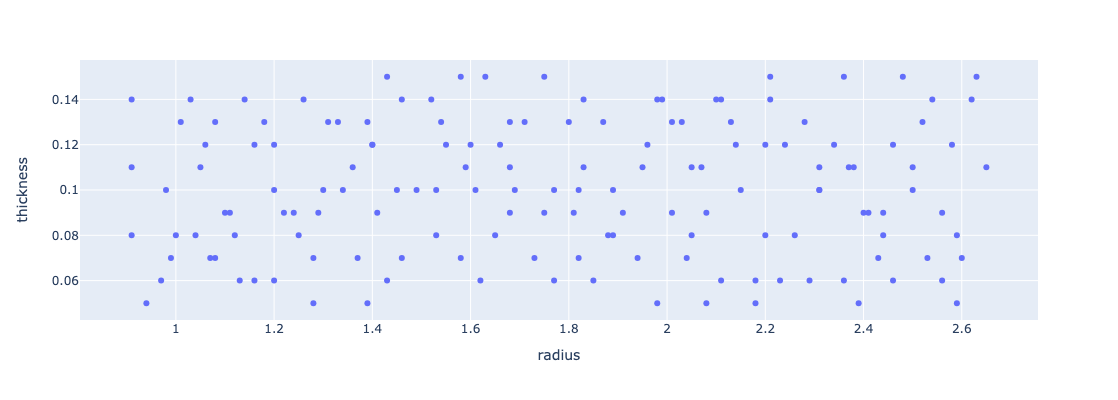

In [11]:
sobol_fig = px.scatter(sobol_samples, x="radius", y="thickness", width=400, height=400)
sobol_fig

### Halton Sequences

Halton sequences are 

In [12]:
def get_halton_samples(bounds, num_samples=10, seed=None):
    sampler = qmc.Halton(d=len(bounds), scramble=False, seed=seed)
    samples = sampler.random(num_samples)
    l_bounds = [bound[0] for bound in bounds.values()]
    u_bounds = [bound[1] for bound in bounds.values()]
    samples = qmc.scale(samples, l_bounds, u_bounds)
    samples=np.round(samples,num_digits)
    return pd.DataFrame(samples, columns=list(bounds.keys()))\
    
def get_halton_samples_extended(bounds, num_samples=10, seed=None):
    sampler = qmc.Halton(d=len(bounds), scramble=False, seed=seed)
    samples = sampler.random(num_samples)
    l_bounds = [bound[0] for bound in bounds.values()]
    u_bounds = [bound[1] for bound in bounds.values()]
    samples = qmc.scale(samples, l_bounds, u_bounds)
    samples = np.round(samples,num_digits)
    halton_samples_1 = pd.DataFrame(samples, columns=list(bounds.keys()))
    _ = sampler.fast_forward(num_samples)
    samples_continued = sampler.random(num_samples*2)
    samples_continued = qmc.scale(samples_continued, l_bounds, u_bounds)
    samples_continued = np.round(samples_continued,num_digits)
    halton_samples_2 = pd.DataFrame(samples_continued, columns=list(bounds.keys()))
    
    return pd.concat([halton_samples_1,halton_samples_2],ignore_index=True,sort=False)

halton_samples = get_halton_samples_extended(bounds, num_samples,seed=None)
halton_samples

,radius,phi,theta,thickness,length
0,0.90,0.00,-1.57,0.05,0.00
1,1.78,0.52,-0.94,0.06,0.18
2,1.34,1.05,-0.31,0.08,0.36
3,2.21,0.17,0.31,0.09,0.55
4,1.12,0.70,0.94,0.11,0.73
...,...,...,...,...,...
145,2.23,0.38,-1.01,0.15,1.56
146,1.14,0.90,-0.38,0.05,1.74
147,2.01,1.43,0.24,0.07,1.92
148,1.58,0.09,0.87,0.08,0.12


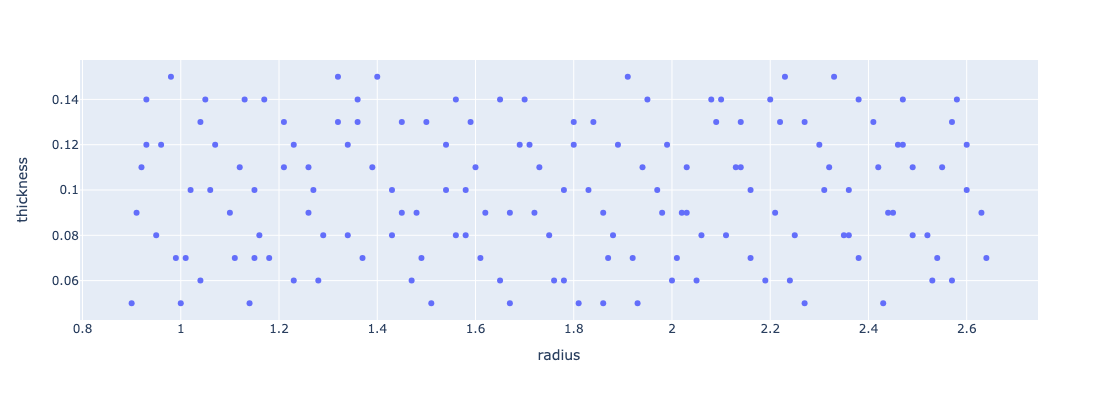

In [13]:
halton_fig = px.scatter(halton_samples, x="radius", y="thickness", width=400, height=400)
halton_fig

### Comparison between sampling methods

The quasi-random methods tend to have better space-filling properties than random or
grid search. Note the large systematic gaps in grid, the large occasional gaps in
random, and the more even distribution of points in LHS and Sobol.

In [14]:
sampling_fns = dict(
    grid=get_grid_samples_extended,
    random=get_random_samples_extended,
    latin_hypercube=get_latin_hypercube_samples_extended,
    sobol=get_sobol_samples_extended,
    halton=get_halton_samples_extended,
)

sample_nums = [5, 50, 100,250,500]
sample_nums.reverse()
        
sample_dfs = []
for name, sampling_fn in sampling_fns.items():
    for num_samples in sample_nums:
        sample_df = sampling_fn(bounds, num_samples)
        sample_df["name"] = name
        sample_df["num_samples"] = num_samples
        sample_dfs.append(sample_df)

compare_df = pd.concat(sample_dfs, names=list(bounds.keys()),axis=0)

125
125
125
125
25
25
25
25
5
5


/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning:

The balance properties of Sobol' points require n to be a power of 2.

/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning:

The balance properties of Sobol' points require n to be a power of 2.

/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning:

The balance properties of Sobol' points require n to be a power of 2.

/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning:

The balance properties of Sobol' points require n to be a power of 2.

/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning:

The balance properties of Sobol' points require n to be 

In [15]:
compare_df

,length,phi,radius,theta,thickness,name,num_samples
0,0.00,0.00,0.90,-1.570796,0.05,grid,500
1,0.00,0.00,0.90,-1.570796,0.10,grid,500
2,0.00,0.00,0.90,-1.570796,0.15,grid,500
3,0.00,0.00,0.90,0.000000,0.05,grid,500
4,0.00,0.00,0.90,0.000000,0.10,grid,500
...,...,...,...,...,...,...,...
10,0.74,0.41,2.54,-1.190000,0.07,halton,5
11,0.93,0.93,0.95,-0.570000,0.08,halton,5
12,1.11,1.45,1.83,0.060000,0.10,halton,5
13,1.29,0.12,1.39,0.690000,0.11,halton,5


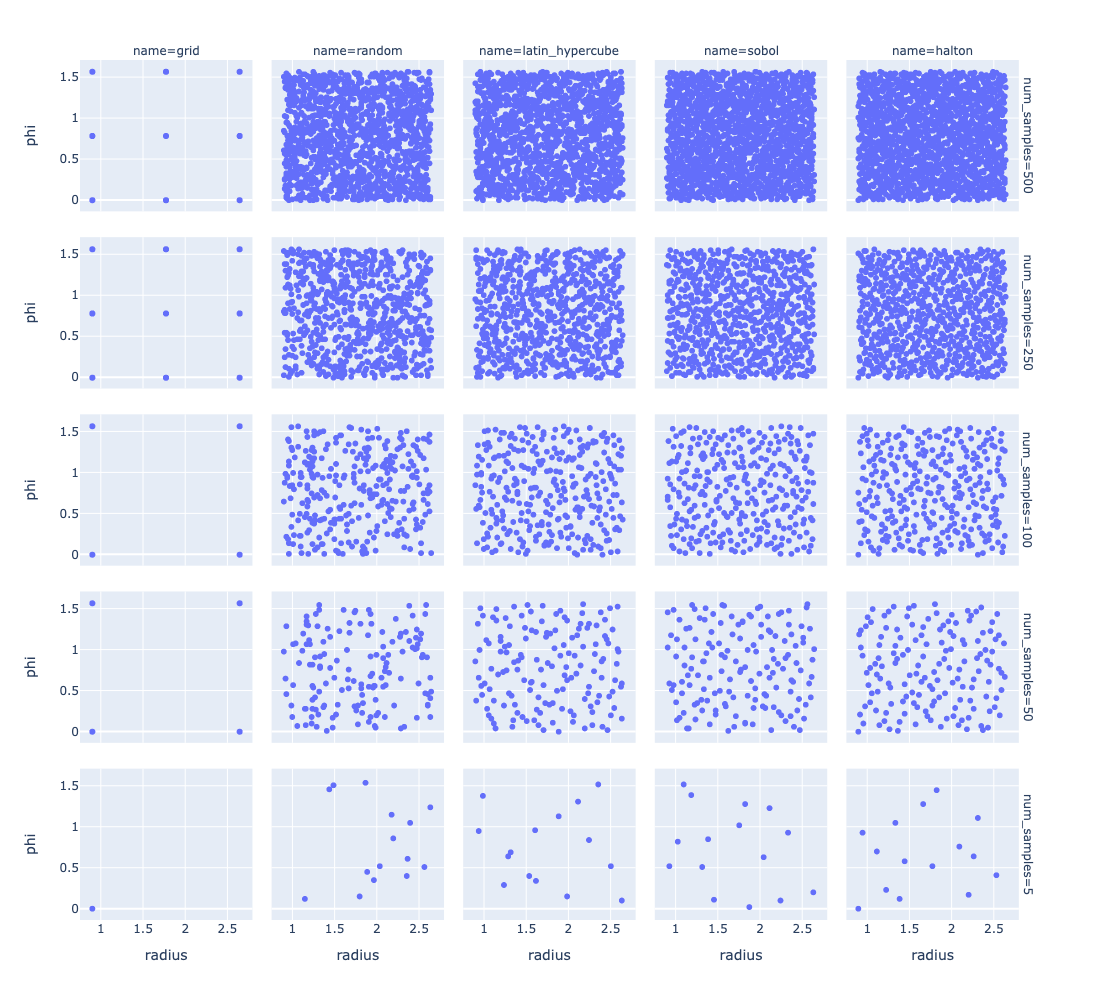

In [16]:
fig = px.scatter(
    compare_df,
    x="radius",
    y="phi",
    facet_row="num_samples",
    facet_col="name",
    width=1000,
    height=1000,
)
fig.show()

### Worsening performance in higher dimensions

As we observe the discrepancy associated with sampling methods in higher dimensions, we
notice that the gap between the quasi-random methods and the random and grid methods
widens. In other words, quasi-random methods increasingly outperform random and grid as
the dimensionality increases.

In [17]:

three_grid= get_grid_samples_extended(
    dict(radius=bounds["radius"], phi=bounds["phi"], theta=bounds["theta"], thickness=bounds["thickness"], length=bounds["length"]), num_samples=50
)
three_random = get_sobol_samples_extended(
    dict(radius=bounds["radius"], phi=bounds["phi"], theta=bounds["theta"], thickness=bounds["thickness"], length=bounds["length"]), num_samples=50
)
three_sobol = get_sobol_samples_extended(
    dict(radius=bounds["radius"], phi=bounds["phi"], theta=bounds["theta"], thickness=bounds["thickness"], length=bounds["length"]), num_samples=50
)
three_LH = get_latin_hypercube_samples_extended(
    dict(radius=bounds["radius"], phi=bounds["phi"], theta=bounds["theta"], thickness=bounds["thickness"], length=bounds["length"]), num_samples=50
)
three_halton = get_halton_samples_extended(
    dict(radius=bounds["radius"], phi=bounds["phi"], theta=bounds["theta"], thickness=bounds["thickness"], length=bounds["length"]), num_samples=50
)

25
25


/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning:

The balance properties of Sobol' points require n to be a power of 2.



In [18]:
# https://community.plotly.com/t/plotting-a-simple-1d-number-line/39169/4
import plotly.graph_objects as go
fig = go.Figure()
x = three_grid["radius"]
fig.add_trace(go.Scatter(
    x=x, y=[0] * len(x), mode='markers', marker_size=20,
))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, 
                 zeroline=True, zerolinecolor='black', zerolinewidth=3,
                 showticklabels=False)
fig.update_layout(height=200, plot_bgcolor='white')
fig.show()

fig3 = go.Figure()
x3 = three_random["radius"]
fig3.add_trace(go.Scatter(
    x=x3, y=[0] * len(x3), mode='markers', marker_size=20,
))
fig3.update_xaxes(showgrid=False)
fig3.update_yaxes(showgrid=False, 
                 zeroline=True, zerolinecolor='black', zerolinewidth=3,
                 showticklabels=False)
fig3.update_layout(height=200, plot_bgcolor='white')
fig3.show()

fig4 = go.Figure()
x4 = three_LH["radius"]
fig4.add_trace(go.Scatter(
    x=x4, y=[0] * len(x4), mode='markers', marker_size=20,
))
fig4.update_xaxes(showgrid=False)
fig4.update_yaxes(showgrid=False, 
                 zeroline=True, zerolinecolor='black', zerolinewidth=3,
                 showticklabels=False)
fig4.update_layout(height=200, plot_bgcolor='white')
fig4.show()

fig2 = go.Figure()
x2 = three_sobol["radius"]
fig2.add_trace(go.Scatter(
    x=x2, y=[0] * len(x2), mode='markers', marker_size=20,
))
fig2.update_xaxes(showgrid=False)
fig2.update_yaxes(showgrid=False, 
                 zeroline=True, zerolinecolor='black', zerolinewidth=3,
                 showticklabels=False)
fig2.update_layout(height=200, plot_bgcolor='white')
fig2.show()

fig5 = go.Figure()
x5 = three_halton["radius"]
fig5.add_trace(go.Scatter(
    x=x5, y=[0] * len(x2), mode='markers', marker_size=20,
))
fig5.update_xaxes(showgrid=False)
fig5.update_yaxes(showgrid=False, 
                 zeroline=True, zerolinecolor='black', zerolinewidth=3,
                 showticklabels=False)
fig5.update_layout(height=200, plot_bgcolor='white')
fig5.show()


In [19]:
# https://community.plotly.com/t/plotting-a-simple-1d-number-line/39169/4
import plotly.graph_objects as go
fig = go.Figure()
x = three_LH["radius"]
fig.add_trace(go.Scatter(
    x=x, y=[0] * len(x), mode='markers', marker_size=20,
))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, 
                 zeroline=True, zerolinecolor='black', zerolinewidth=3,
                 showticklabels=False)
fig.update_layout(height=200, plot_bgcolor='white')
fig.show()

fig3 = go.Figure()
x3 = three_LH["phi"]
fig3.add_trace(go.Scatter(
    x=x3, y=[0] * len(x3), mode='markers', marker_size=20,
))
fig3.update_xaxes(showgrid=False)
fig3.update_yaxes(showgrid=False, 
                 zeroline=True, zerolinecolor='black', zerolinewidth=3,
                 showticklabels=False)
fig3.update_layout(height=200, plot_bgcolor='white')
fig3.show()

fig4 = go.Figure()
x4 = three_LH["theta"]
fig4.add_trace(go.Scatter(
    x=x4, y=[0] * len(x4), mode='markers', marker_size=20,
))
fig4.update_xaxes(showgrid=False)
fig4.update_yaxes(showgrid=False, 
                 zeroline=True, zerolinecolor='black', zerolinewidth=3,
                 showticklabels=False)
fig4.update_layout(height=200, plot_bgcolor='white')
fig4.show()

fig2 = go.Figure()
x2 = three_LH["thickness"]
fig2.add_trace(go.Scatter(
    x=x2, y=[0] * len(x2), mode='markers', marker_size=20,
))
fig2.update_xaxes(showgrid=False)
fig2.update_yaxes(showgrid=False, 
                 zeroline=True, zerolinecolor='black', zerolinewidth=3,
                 showticklabels=False)
fig2.update_layout(height=200, plot_bgcolor='white')
fig2.show()

fig5 = go.Figure()
x5 = three_LH["length"]
fig5.add_trace(go.Scatter(
    x=x5, y=[0] * len(x5), mode='markers', marker_size=20,
))
fig5.update_xaxes(showgrid=False)
fig5.update_yaxes(showgrid=False, 
                 zeroline=True, zerolinecolor='black', zerolinewidth=3,
                 showticklabels=False)
fig5.update_layout(height=200, plot_bgcolor='white')
fig5.show()


In [20]:
# https://community.plotly.com/t/rotating-3d-plots-with-plotly/34776/2
# https://community.plotly.com/t/how-to-export-animation-and-save-it-in-a-video-format-like-mp4-mpeg-or/64621/2
import plotly.graph_objects as go
import numpy as np
import plotly.io as pio

x, y, z = three_halton["radius"], three_halton["phi"], three_halton["theta"]

fig = go.Figure(go.Scatter3d(x=x, y=y, z=z, mode="markers"))

x_eye = -1.25
y_eye = 2
z_eye = 1.0

fig.update_layout(
    title="Animation Test",
    width=600,
    height=600,
    scene_camera_eye=dict(x=x_eye, y=y_eye, z=z_eye),
    updatemenus=[
        dict(
            type="buttons",
            showactive=False,
            y=1,
            x=0.8,
            xanchor="left",
            yanchor="bottom",
            pad=dict(t=45, r=10),
            buttons=[
                dict(
                    label="Play",
                    method="animate",
                    args=[
                        None,
                        dict(
                            frame=dict(duration=5, redraw=True),
                            transition=dict(duration=0),
                            fromcurrent=True,
                            mode="immediate",
                        ),
                    ],
                )
            ],
        )
    ],
)


def rotate_z(x, y, z, theta):
    w = x + 1j * y
    return np.real(np.exp(1j * theta) * w), np.imag(np.exp(1j * theta) * w), z


frames = []
pil_frames = []
for t in np.arange(0, 3.14, 0.025):
    xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
    frames.append(go.Frame(layout=dict(scene_camera_eye=dict(x=xe, y=ye, z=ze))))
fig.frames = frames

fig.show()

In [21]:
dim_discrepancies = []
# sample_dfs = []
dim_nums = [2, 3, 4,5]
num_samples = 100
for name, sampling_fn in sampling_fns.items():
    for num_dims in dim_nums:
        bounds = {f"x{i+1}": [0, 1] for i in range(num_dims)}
        sample_df = sampling_fn(bounds, num_samples)
        discrepancy = qmc.discrepancy(sample_df.values)
        dim_discrepancies.append(dict(name=name, num_samples=sample_df.shape[0], discrepancy=discrepancy, num_dims=num_dims))
        # sample_dfs.append(sample_df)

dim_discrepancy_df = pd.DataFrame(dim_discrepancies)
pd.pivot_table(
    dim_discrepancy_df.drop("num_samples", axis=1),
    index=["num_dims", "discrepancy", "name"],
)


1024
16384
81
243
64
64
25
25


Empty DataFrame
Columns: []
Index: [(2, 3.058674438793929e-05, latin_hypercube), (2, 4.9329366659689455e-05, sobol), (2, 8.2916533249211e-05, halton), (2, 0.0011603944944100775, random), (2, 0.0020605671144207083, grid), (3, 8.396794575515898e-05, latin_hypercube), (3, 0.00011483612926754816, sobol), (3, 0.00014073802969161164, halton), (3, 0.0015081912046548407, random), (3, 0.030860742234229965, grid), (4, 0.00019887315745537038, latin_hypercube), (4, 0.00024777422568611485, sobol), (4, 0.0002924040390952509, halton), (4, 0.002379571969389316, random), (4, 0.14679486263526886, grid), (5, 0.0003993632732945951, latin_hypercube), (5, 0.00045266537925514605, sobol), (5, 0.0006042406537101197, halton), (5, 0.00618792471291818, random), (5, 0.9398361645608277, grid)]

In [22]:
dim_discrepancies = []
# sample_dfs = []
dim_nums = [2, 3,4,5]
num_samples = 50
for name, sampling_fn in sampling_fns.items():
    for num_dims in dim_nums:
        bounds = {f"x{i+1}": [0, 1] for i in range(num_dims)}
        sample_df = sampling_fn(bounds, num_samples)
        discrepancy = qmc.discrepancy(sample_df.values)
        dim_discrepancies.append(dict(name=name, num_samples=sample_df.shape[0], discrepancy=discrepancy, num_dims=num_dims))
        # sample_dfs.append(sample_df)

dim_discrepancy_df = pd.DataFrame(dim_discrepancies)
pd.pivot_table(
    dim_discrepancy_df.drop("num_samples", axis=1),
    index=["num_dims", "discrepancy", "name"],
)


128
1024
27
81
16
64
25
25


/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning:

The balance properties of Sobol' points require n to be a power of 2.



Empty DataFrame
Columns: []
Index: [(2, 8.038256664799626e-05, latin_hypercube), (2, 0.00011176137779189688, sobol), (2, 0.00030278282219975416, halton), (2, 0.0038199491444375067, random), (2, 0.0044605522656300245, grid), (3, 0.00021412652533214782, latin_hypercube), (3, 0.00034806553730137857, sobol), (3, 0.000510870281790865, halton), (3, 0.007015526218011159, random), (3, 0.05642451312348573, grid), (4, 0.0005213353317623515, latin_hypercube), (4, 0.0007136670123459865, sobol), (4, 0.000896083069886755, halton), (4, 0.008014877314028501, random), (4, 0.18819409283894184, grid), (5, 0.0009846866342817506, latin_hypercube), (5, 0.001297262565050028, sobol), (5, 0.002532152216820238, halton), (5, 0.007773042728101531, random), (5, 0.9398361645608277, grid)]

In [23]:
dim_discrepancies = []
# sample_dfs = []
dim_nums = [2, 3, 4,5]
num_samples = 250
for name, sampling_fn in sampling_fns.items():
    for num_dims in dim_nums:
        bounds = {f"x{i+1}": [0, 1] for i in range(num_dims)}
        sample_df = sampling_fn(bounds, num_samples)
        discrepancy = qmc.discrepancy(sample_df.values)
        dim_discrepancies.append(dict(name=name, num_samples=sample_df.shape[0], discrepancy=discrepancy, num_dims=num_dims))
        # sample_dfs.append(sample_df)

dim_discrepancy_df = pd.DataFrame(dim_discrepancies)
pd.pivot_table(
    dim_discrepancy_df.drop("num_samples", axis=1),
    index=["num_dims", "discrepancy", "name"],
)


32768
4194304
729
2187
64
256
125
125


/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning:

The balance properties of Sobol' points require n to be a power of 2.



Empty DataFrame
Columns: []
Index: [(2, 2.1760922762847912e-05, latin_hypercube), (2, 2.2885840684772063e-05, sobol), (2, 2.7827276122938116e-05, halton), (2, 0.0005750973626639233, random), (2, 0.0008546188115110542, grid), (3, 4.36350824728482e-05, sobol), (3, 4.4499675646791914e-05, latin_hypercube), (3, 5.150209415805129e-05, halton), (3, 0.0010723272436952147, random), (3, 0.013348058610641367, grid), (4, 7.992113323695982e-05, sobol), (4, 9.149656539664264e-05, latin_hypercube), (4, 9.397818706724514e-05, halton), (4, 0.0017420594641932574, random), (4, 0.08220796239760442, grid), (5, 0.0001343253141663503, sobol), (5, 0.00016190475859323428, halton), (5, 0.00016546427432384547, latin_hypercube), (5, 0.00133826412806215, random), (5, 0.2013654873759494, grid)]